# **Nama       : Wilson Boyaron Hutagalung**
# **NIM        : 2209106035**
# **Matakuliah : Visi Komputer**

#### Link Dataset: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset

## Import Library
Bagian ini mengimpor pustaka-pustaka penting seperti os untuk pengelolaan file, random dan numpy untuk operasi acak dan numerik, matplotlib dan seaborn untuk visualisasi data, cv2 untuk pemrosesan gambar, tensorflow untuk membangun dan melatih model CNN, serta modul seperti ImageDataGenerator untuk augmentasi data, Sequential dan lapisan seperti Conv2D dan BatchNormalization untuk arsitektur model, Adam untuk optimasi, EarlyStopping dan ReduceLROnPlateau untuk callback pelatihan, class_weight untuk menangani ketidakseimbangan kelas, serta classification_report dan confusion_matrix untuk evaluasi performa model, yang semuanya mendukung pengembangan dan analisis model klasifikasi gambar mobil dan sepeda motor.

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import collections
from tensorflow.keras.layers import BatchNormalization

## Split Dataset
Fungsi split_dataset (yang dikomentari) dirancang untuk membagi dataset dari direktori asal ke direktori pelatihan (80%), validasi (10%), dan pengujian (10%) dengan memastikan rasio total 1.0, mengacak gambar dalam setiap kelas (mobil dan sepeda motor) untuk menghindari bias, dan menyalinnya ke subdirektori yang sesuai menggunakan shutil.copy2, memungkinkan organisasi data yang terstruktur untuk pelatihan model machine learning, meskipun fungsi ini tidak dijalankan karena dataset diasumsikan telah dibagi sebelumnya.

#### Kalau sudah displit datasetnya, Code dibawah ini dijadikan Comment.

In [ ]:
def split_dataset(original_dir, output_base_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Rasio harus total 1.0"
    
    classes = os.listdir(original_dir)
    
    for class_name in classes:
        class_path = os.path.join(original_dir, class_name)
        
        if not os.path.isdir(class_path):
            continue
        
        images = os.listdir(class_path)
        random.shuffle(images)  
        
        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(output_base_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(split_dir, img)
                shutil.copy2(src_path, dst_path)
        
    print("Dataset berhasil dibagi ke dalam folder Train, Val, dan Test.")
    
split_dataset('./Car-Bike-Dataset', './DataSets-CarBike')

Bagian ini mengatur seed acak untuk TensorFlow, NumPy, dan Python ke nilai 42, memastikan reproduksibilitas hasil dengan menjamin bahwa operasi acak seperti inisialisasi bobot model, pengacakan data, atau augmentasi menghasilkan output yang konsisten setiap kali kode dijalankan, yang penting untuk debugging dan perbandingan performa model dalam pengembangan machine learning.

In [3]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Set seed untuk reproducibility
Kode ini mendefinisikan jalur direktori untuk data pelatihan, validasi, dan pengujian, lalu memeriksa keberadaan setiap direktori menggunakan os.path.exists dan memastikan direktori tidak kosong dengan os.listdir, dengan melemparkan error jika kondisi tidak terpenuhi, untuk menjamin bahwa dataset telah disiapkan dengan benar dan berisi subfolder kelas (misalnya, 'Mobil' dan 'Sepeda Motor') sebelum memulai proses pelatihan model, mencegah kegagalan akibat struktur data yang salah.

In [4]:
train_dir = './DataSets-CarBike/train'
val_dir = './DataSets-CarBike/val'
test_dir = './DataSet-CarBike/test'

for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Direktori {directory} tidak ditemukan. Pastikan dataset telah dibagi dengan benar.")
    if not os.listdir(directory):
        raise ValueError(f"Direktori {directory} kosong. Pastikan folder berisi subfolder kelas dengan gambar.")

## ImageDataGenerator dengan augmentasi & preprocessing
Bagian ini mendefinisikan ukuran gambar 150x150 piksel dan ukuran batch 32. ImageDataGenerator digunakan untuk pra-pemrosesan dan augmentasi data. train_datagen menerapkan normalisasi (membagi nilai piksel dengan 255 untuk rentang [0,1]), rotasi hingga 20 derajat, zoom dan shear 20%, pergeseran lebar/tinggi 20%, flip horizontal, serta penyesuaian kecerahan dalam rentang [0.8, 1.2] dengan fill_mode='nearest' untuk meningkatkan variasi data pelatihan. Sementara itu, val_datagen dan test_datagen hanya menerapkan normalisasi. Preprocessing ini menstandardisasi input model, mempercepat konvergensi, dan mencegah overfitting dengan augmentasi yang membuat model lebih robust terhadap variasi gambar di dunia nyata.

In [5]:
img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  
    zoom_range=0.2,     
    shear_range=0.2,   
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

## Load gambar & resize
Kode ini menggunakan flow_from_directory untuk memuat gambar dari direktori pelatihan, validasi, dan pengujian ke dalam generator, dengan mengubah ukuran gambar ke 150x150 piksel, menetapkan batch size (16 untuk pelatihan dan validasi, 1 untuk pengujian), menggunakan mode klasifikasi kategorikal untuk label one-hot encoded, mengacak data pelatihan dan validasi untuk mencegah bias urutan, tetapi tidak mengacak data pengujian agar prediksi dapat diselaraskan dengan label asli, memungkinkan model memproses data secara efisien dalam batch untuk pelatihan dan evaluasi.

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Alasan Preprocessing dilakukan untuk mempersiapkan data gambar agar sesuai dengan kebutuhan model machine learning dan meningkatkan performa pelatihan. Langkah utama dalam preprocessing meliputi:
1. **Normalisasi**: Membagi nilai piksel dengan 255 untuk mengubah rentang nilai dari [0,255] menjadi [0,1]. Ini membantu model konvergen lebih cepat karena gradien menjadi lebih stabil selama optimasi, dan mencegah fitur dengan skala besar mendominasi pembelajaran.
2. **Augmentasi Data**: Teknik seperti rotasi, zoom, shear, pergeseran, dan flip horizontal diterapkan pada data pelatihan untuk meningkatkan variasi data. Augmentasi ini mensimulasikan variasi dunia nyata (misalnya, sudut pandang atau posisi kendaraan yang berbeda), sehingga model menjadi lebih robust dan mampu menggeneralisasi dengan baik pada data baru, sekaligus mengurangi risiko overfitting.
3. **Konsistensi Input**: Mengubah ukuran gambar ke dimensi yang seragam (150x150 piksel) memastikan bahwa model menerima input dengan format yang konsisten, yang diperlukan untuk arsitektur CNN yang memiliki lapisan konvolusi dengan ukuran filter tetap.
Preprocessing ini penting untuk memastikan data siap digunakan, meningkatkan efisiensi pelatihan, dan menghasilkan model yang lebih akurat dan tahan terhadap variasi data.


## Distribusi kelas
Bagian ini mencetak distribusi kelas pada data pelatihan menggunakan collections.Counter untuk menghitung jumlah gambar per kelas (misalnya, Mobil dan Sepeda Motor) dari train_generator.classes, serta mengekstrak nama-nama kelas (seperti ['Sepeda Motor', 'Mobil']) dari train_generator.class_indices, bertujuan untuk menganalisis apakah dataset seimbang atau tidak, yang penting untuk menentukan perlunya bobot kelas guna mencegah bias model terhadap kelas mayoritas.

In [7]:
print("Distribusi kelas training:", collections.Counter(train_generator.classes))
class_names = list(train_generator.class_indices.keys())
print("Label kelas:", class_names)

Distribusi kelas training: Counter({np.int32(0): 1600, np.int32(1): 1600})
Label kelas: ['Bike', 'Car']


## Visualisasi Sample Gambar
Kode ini menampilkan 9 gambar sampel dari data pelatihan dalam grid 3x3 menggunakan plt.figure, mengambil batch pertama dari train_generator, menampilkan setiap gambar dengan plt.imshow, mengonversi label one-hot encoded ke indeks kelas dengan np.argmax untuk menampilkan nama kelas (misalnya, 'Mobil' atau 'Sepeda Motor') sebagai judul, dan mematikan sumbu untuk visualisasi yang lebih rapi, bertujuan untuk memverifikasi bahwa data dimuat dengan benar dan augmentasi diterapkan seperti yang diharapkan.

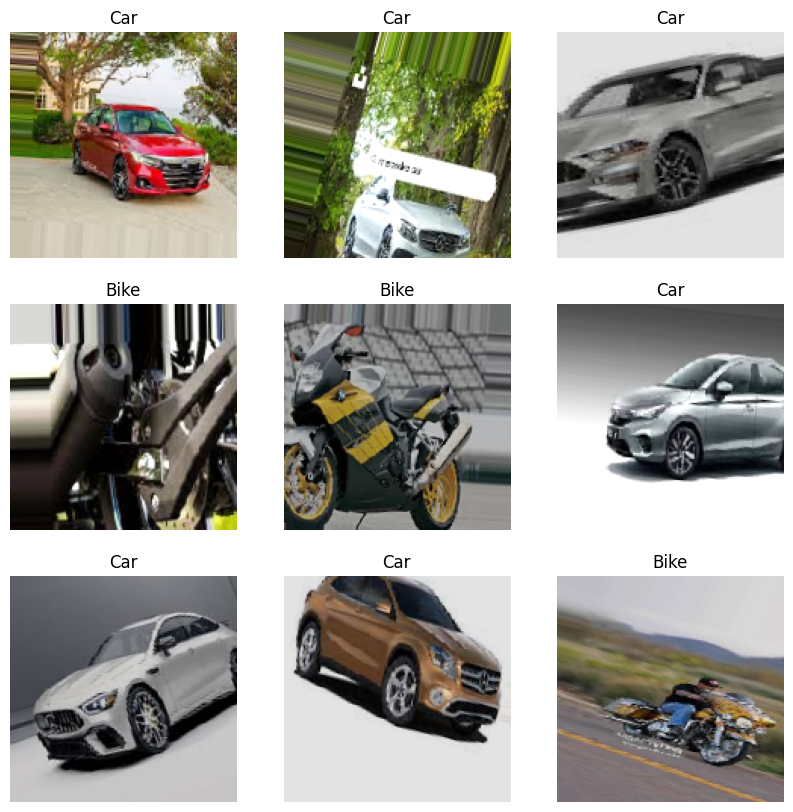

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img_display = images[i]
        plt.imshow(img_display)
        predicted_class_index = np.argmax(labels[i])
        plt.title(class_names[predicted_class_index])
        plt.axis("off")
    break
plt.show()

Bagian ini menghitung bobot kelas menggunakan class_weight.compute_class_weight dengan mode 'balanced' untuk memberikan bobot lebih besar pada kelas minoritas berdasarkan distribusi kelas pelatihan, mengonversi hasilnya ke kamus dengan dict(enumerate(...)) untuk digunakan selama pelatihan, dan mencetak bobot kelas, yang bertujuan untuk mengatasi ketidakseimbangan dataset agar model tidak bias terhadap kelas mayoritas dan meningkatkan performa pada kelas minoritas.

In [9]:
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


## Model CNN
Kode ini mendefinisikan model Convolutional Neural Network (CNN) menggunakan Keras Sequential API. Model ini terdiri dari empat lapisan konvolusi (Conv2D) dengan jumlah filter berturut-turut 32, 64, 128, dan 64, masing-masing menggunakan kernel 3x3 dan aktivasi ReLU untuk mengekstrak fitur dari gambar berukuran input 150x150 piksel dengan 3 kanal warna (RGB). Setiap lapisan Conv2D diikuti oleh BatchNormalization untuk menstabilkan dan mempercepat pelatihan, serta MaxPooling2D (2x2) untuk mengurangi dimensi spasial, sehingga mengurangi kompleksitas komputasi dan risiko overfitting. Setelah lapisan konvolusi, data diubah menjadi vektor 1D menggunakan lapisan Flatten. Untuk mencegah overfitting, dua lapisan Dropout diterapkan dengan tingkat dropout 0.3 dan 0.5. Model diakhiri dengan dua lapisan Dense: lapisan pertama dengan 128 neuron dan aktivasi ReLU, serta lapisan output dengan 2 neuron dan aktivasi softmax untuk klasifikasi biner (misalnya, Mobil/Sepeda Motor). Fungsi model.summary() digunakan untuk menampilkan ringkasan arsitektur model, termasuk jumlah parameter dan struktur lapisan, sehingga memudahkan analisis dan debugging. Arsitektur ini dirancang untuk klasifikasi gambar yang efektif dan robust.

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),  
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.3),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 569,986 (2.17 MB)

 Trainable params: 569,410 (2.17 MB)

 Non-trainable params: 576 (2.25 KB)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 569,986 (2.17 MB)

 Trainable params: 569,410 (2.17 MB)

 Non-trainable params: 576 (2.25 KB)

## Compile Model dan Callback Early Stopping
Kode ini mengompilasi model CNN dengan optimizer Adam (learning rate 0.0005) untuk pembaruan bobot yang stabil, menggunakan `categorical_crossentropy` sebagai fungsi kerugian untuk klasifikasi biner (misalnya, Mobil/Sepeda Motor), dan metrik `accuracy` untuk evaluasi performa. Selain itu, callback `EarlyStopping` memantau `val_loss` dengan `patience=8` untuk menghentikan pelatihan jika tidak ada perbaikan, mengembalikan bobot terbaik, sementara `ReduceLROnPlateau` mengurangi learning rate (faktor 0.2, minimum 0.00001) jika `val_loss` tidak membaik setelah 5 epoch, memastikan pelatihan efisien dan mencegah overfitting.

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

## Kompilasi dan Melatih Model
Kode ini melatih model CNN menggunakan model.fit dengan data dari train_generator selama maksimal 50 epoch, memvalidasi performa dengan val_generator, menerapkan bobot kelas untuk menangani ketidakseimbangan, menggunakan callback early_stop dan reduce_lr untuk efisiensi pelatihan, dan menyimpan metrik pelatihan (akurasi dan kerugian) dalam objek history, bertujuan untuk mengoptimalkan model agar dapat mengklasifikasikan gambar mobil dan sepeda motor dengan baik.


In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],  
    verbose=1
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
  9/100 ━━━━━━━━━━━━━━━━━━━━ 1:13 808ms/step - accuracy: 0.5105 - loss: 1.6426

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 836ms/step - accuracy: 0.6365 - loss: 1.0750 - val_accuracy: 0.5000 - val_loss: 1.7822 - learning_rate: 5.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 652ms/step - accuracy: 0.8012 - loss: 0.4690 - val_accuracy: 0.5050 - val_loss: 0.8269 - learning_rate: 5.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 618ms/step - accuracy: 0.8174 - loss: 0.4104 - val_accuracy: 0.7700 - val_loss: 0.4505 - learning_rate: 5.0000e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 628ms/step - accuracy: 0.8535 - loss: 0.3412 - val_accuracy: 0.6800 - val_loss: 0.6292 - learning_rate: 5.0000e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 607ms/step - accuracy: 0.8690 - loss: 0.3230 - val_accuracy: 0.7075 - val_loss: 0.6629 - learning_rate: 5.0000e-04
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 606ms/step - accuracy: 0.8924 - loss: 0.2574 - val_accuracy: 0.8600 - val_loss: 0.3162 - learning_rate: 5.0000e-04
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 604ms/step - 

## Evaluasi Model
Bagian ini mengevaluasi model pada data pengujian menggunakan model.evaluate dengan test_generator, menghitung kerugian dan akurasi, lalu mencetak akurasi pengujian dalam persentase dan kerugian dengan empat desimal, bertujuan untuk mengukur kemampuan generalisasi model pada data yang belum pernah dilihat untuk menilai performa klasifikasi mobil dan sepeda motor.

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")    

400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9830 - loss: 0.0399
Test Accuracy: 98.25%
Test Loss: 0.0376


## Visualisasi Hasil
Kode ini membuat dua subplot berdampingan untuk memvisualisasikan akurasi dan kerugian model selama pelatihan, dengan subplot kiri menampilkan akurasi pelatihan dan validasi serta subplot kanan menampilkan kerugian pelatihan dan validasi dari history.history, menggunakan label dan legenda untuk kejelasan, serta plt.tight_layout untuk tata letak rapi, bertujuan untuk menganalisis perkembangan performa model dan mendeteksi masalah seperti overfitting jika akurasi validasi jauh lebih rendah dari pelatihan.

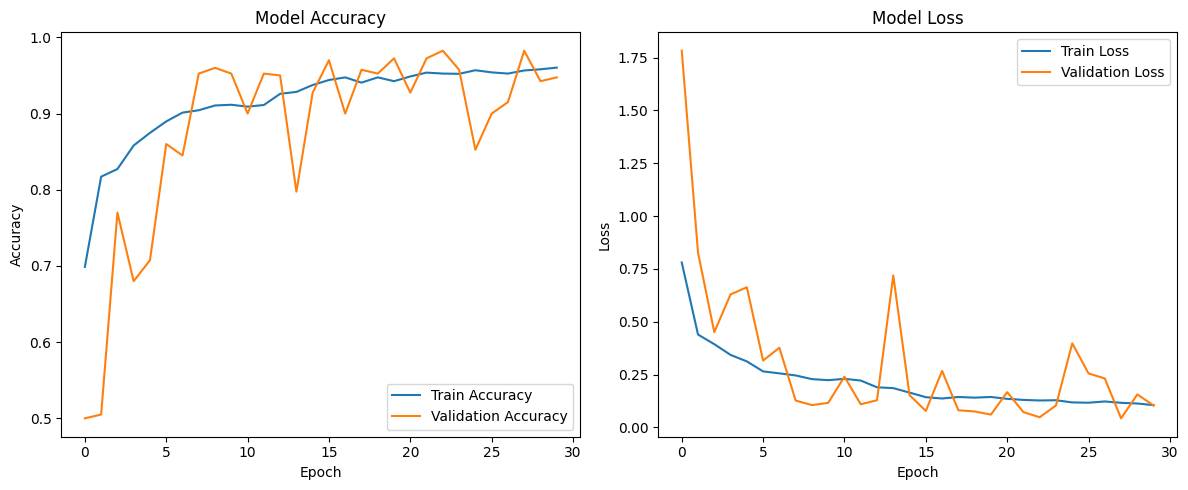

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Bagian ini mereset test_generator, memprediksi kelas untuk data pengujian dengan model.predict, mengonversi probabilitas ke kelas dengan np.argmax, menghitung matriks kebingungan dengan confusion_matrix untuk membandingkan label sebenarnya dan prediksi, lalu memvisualisasikannya sebagai heatmap menggunakan sns.heatmap dengan label kelas (misalnya, 'Mobil', 'Sepeda Motor') dan warna biru, bertujuan untuk mengevaluasi performa model dengan melihat seberapa sering prediksi benar atau salah per kelas.

## Confusion Matrix
Bagian ini mereset test_generator, memprediksi kelas untuk data pengujian dengan model.predict, mengonversi probabilitas ke kelas dengan np.argmax, menghitung matriks kebingungan dengan confusion_matrix untuk membandingkan label sebenarnya dan prediksi, lalu memvisualisasikannya sebagai heatmap menggunakan sns.heatmap dengan label kelas (misalnya, 'Mobil', 'Sepeda Motor') dan warna biru, bertujuan untuk mengevaluasi performa model dengan melihat seberapa sering prediksi benar atau salah per kelas.

400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


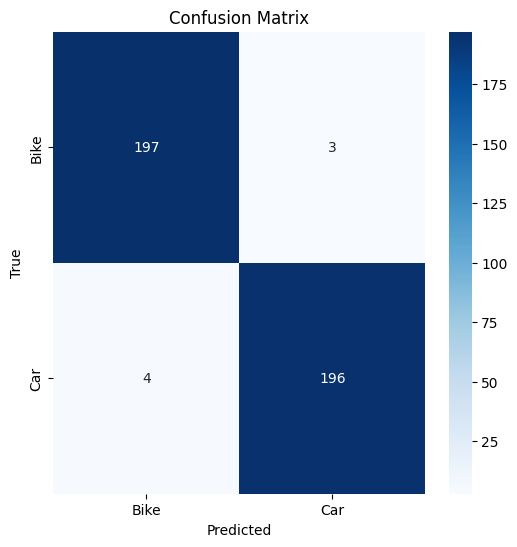

In [16]:
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Classification Report
Kode ini mencetak laporan klasifikasi menggunakan classification_report, yang menyediakan metrik seperti presisi, recall, dan F1-score untuk setiap kelas (Mobil dan Sepeda Motor) berdasarkan label sebenarnya dan prediksi, bertujuan untuk memberikan analisis rinci tentang performa model, terutama pada dataset yang tidak seimbang, untuk memahami kekuatan dan kelemahan klasifikasi per kelas.

In [17]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

        Bike       0.98      0.98      0.98       200
         Car       0.98      0.98      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



## Menampilkan contoh prediksi acak dari data test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


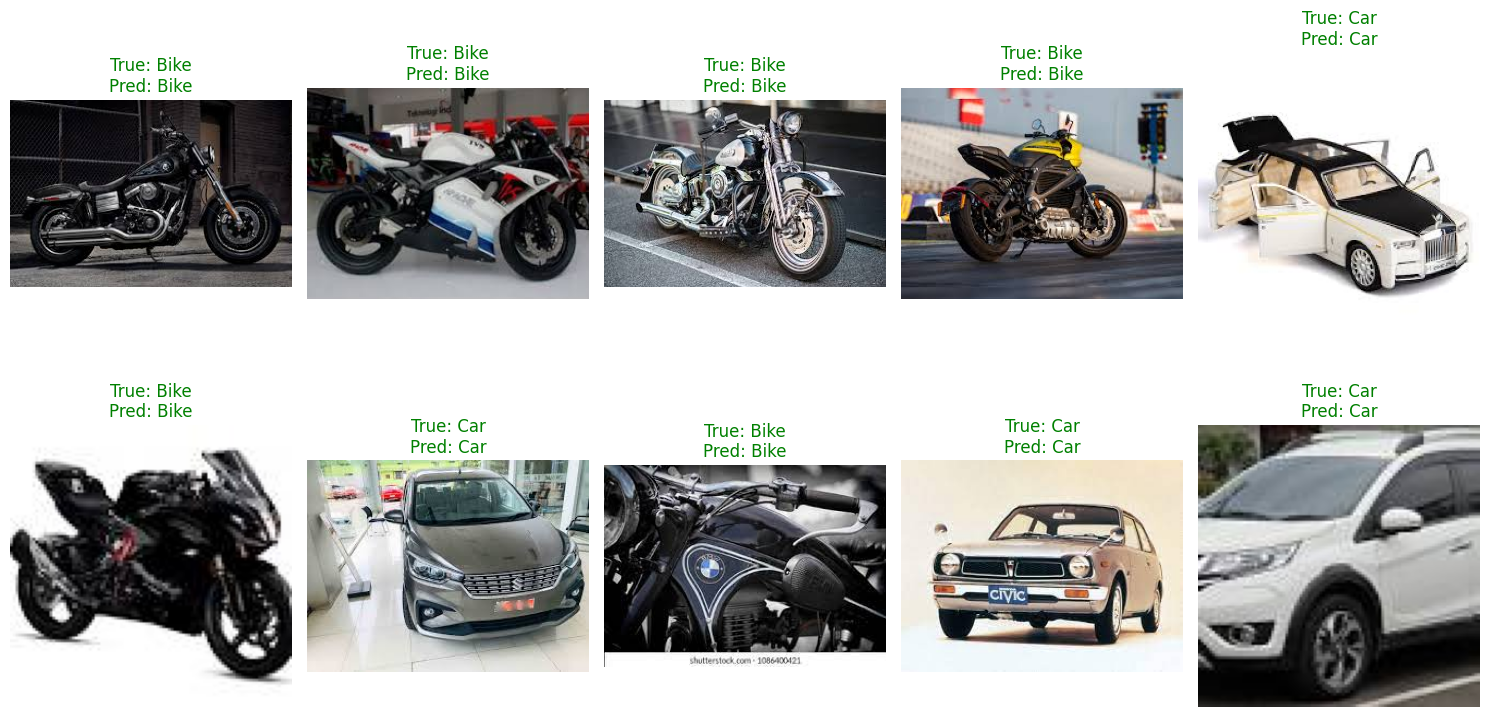

In [20]:
def visualize_sample_predictions(model, folder_path, class_names, num_samples=10, target_size=(150, 150)):
    image_paths = []
    labels = []

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        for img_file in os.listdir(class_folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_folder, img_file))
                labels.append(class_name)

    indices = random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        true_label = labels[idx]

        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(image_rgb, target_size)
        normalized = resized.astype(np.float32) / 255.0
        input_img = np.expand_dims(normalized, axis=0)

        prediction = model.predict(input_img)
        pred_label = class_names[np.argmax(prediction[0])]

        plt.subplot(2, (num_samples + 1) // 2, i + 1)
        plt.imshow(image_rgb)
        plt.title(f"True: {true_label}\nPred: {pred_label}",
                  color='green' if true_label == pred_label else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_sample_predictions(model, test_dir, class_names, num_samples=10)